In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## Load network and data_generator

In [5]:
args = load_args('../nn_configs/C/003-resnet_d3_zt_3d.yml')

In [6]:
dg_test = load_data(**args, only_test=True)

In [7]:
model = load_model(args)

In [8]:
X, y = dg_test[0]

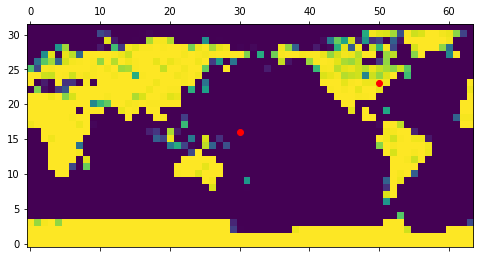

In [42]:
plt.matshow(X[0, ..., -3], origin='lower')
plt.scatter([50], [23], c='r')
plt.scatter([30], [16], c='r')

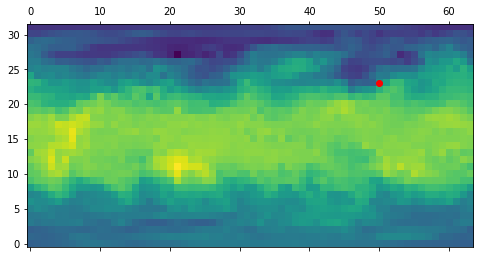

In [28]:
plt.matshow(y[0, ..., 1], origin='lower')
plt.scatter([50], [23], c='r')

In [13]:
Xi = X[:1]

In [74]:
lat_idx = 16; lon_idx = 30
# lat_idx = 23; lon_idx = 50

In [75]:
Xtf = tf.convert_to_tensor(Xi)
with tf.GradientTape() as tape:
    tape.watch(Xtf)
    p = model(Xtf)
    point = p[0, lat_idx, lon_idx, 1]

In [76]:
grads = tape.gradient(point, Xtf).numpy()[0]

In [77]:
xlabels = np.concatenate([dg_test.data.level_names.isel(level=dg_test.not_const_idxs).values]*2+[dg_test.data.level_names.values])

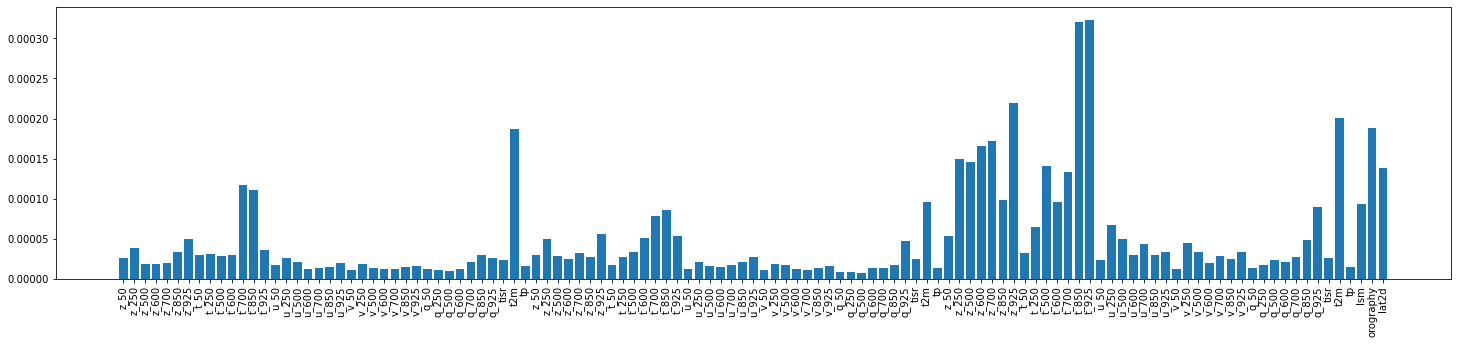

In [78]:
plt.figure(figsize=(25, 5))
plt.bar(np.arange(len(xlabels)), grads.std((0, 1)))
plt.xticks(np.arange(len(xlabels)), xlabels, rotation=90);

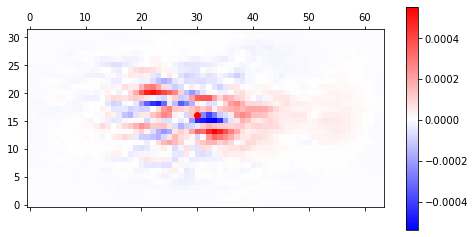

In [80]:
plt.matshow(grads[..., -26], origin='lower', cmap='bwr')
plt.colorbar()
plt.scatter([lon_idx], [lat_idx], c='r')

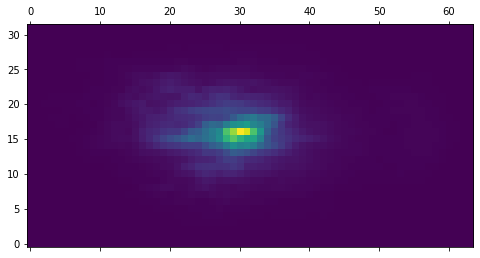

In [48]:
plt.matshow(grads.std(2), origin='lower')

In [37]:
grads.shape

(32, 64, 117)

In [15]:
Xi.shape, p.shape

((1, 32, 64, 117), TensorShape([1, 32, 64, 2]))